# Assignment
Build the AlexNet architecture and train it on the CIFAR10 dataset.

You may resize some of the kernel sizes (mainly the first one) and the number of kernels because CIFAR100 is a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

You may resize the number of kernels used per layer if it speeds up training and/or preserves accuracy. The exact AlexNet architecture and number of units will not work.

Report training, validation and test errors. Which hyperparameters did you change to improve performance?

**MAKE SURE YOU USE A GPU!** Top menu select "Runtime", then "Runtime Type". Make sure "Hardware Accelerator" has the option "GPU" selected.

Tips:
- Start with only a few of a layers and check if the network can learn.
- Add units and layers progressively.
- Kernels that are too large or too much pooling will reduce the size of layer ouputs
- Try Batch Norm and Dropout
- If you don't reproduce the exact architecture, that is fine. Explain what you changed and why!.
- Functional API!


In [13]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

#TF Version & GPUs available
print('TF Version: ' + str(tf.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Access to GPU details:
!nvidia-smi

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TF Version: 2.17.0
Num GPUs Available:  1
Mon Oct  7 17:34:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              33W /  70W |   7433MiB / 15360MiB |      0%      Default |
|                                         |  

In [14]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

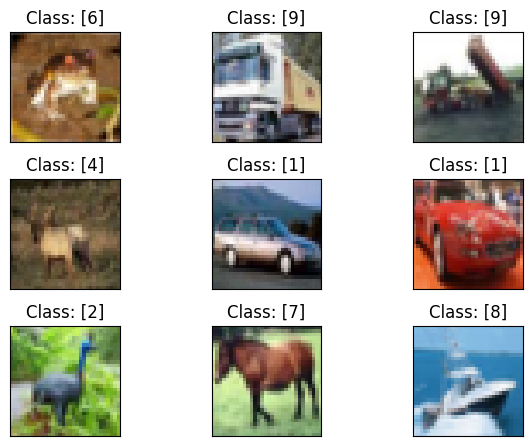

In [15]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train_full[i], interpolation='none')
  plt.title('Class: {}'.format(y_train_full[i]))
  plt.xticks([])
  plt.yticks([])

In [16]:
X_train_full.shape

(50000, 32, 32, 3)

In [17]:
y_train_full.shape

(50000, 1)

In [18]:
# Train, Validate & Test
# Split train_full into train & test
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models,initializers
from tensorflow.keras.initializers import HeUniform, HeNormal, GlorotUniform, GlorotNormal

import random
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

K.clear_session()

# Convert data to float32 and normalize to [0, 1]
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Split the training data into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Compute the mean and std from the training data (after the split)
mean = np.mean(X_train, axis=(0, 1, 2), keepdims=True)
std = np.std(X_train, axis=(0, 1, 2), keepdims=True)

# Standardize the training, validation, and test datasets using the training mean & std
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std  # Use the same mean and std as training

# Check the standardized data
print("Training data mean after standardization:", np.mean(X_train, axis=(0, 1, 2)))
print("Training data std after standardization:", np.std(X_train, axis=(0, 1, 2)))

print("===============================================")
print("X_train.shape", X_train.shape)  # (40000, 32, 32, 3)
print("y_train.shape",y_train.shape)  # (40000, 1)
print("===============================================")
print("X_val.shape",X_val.shape)    # (10000, 32, 32, 3)
print("y_val.shape",y_val.shape)    # (10000, 1)
print("===============================================")
print("X_test.shape", X_test.shape)             # (10000, 32, 32, 3)
print("y_test.shape", y_test.shape)             # (10000, 1)

Training data mean after standardization: [-4.5200281e-06 -2.1969572e-06  3.4952118e-06]
Training data std after standardization: [1.0000029 0.9999997 1.0000001]
X_train.shape (40000, 32, 32, 3)
y_train.shape (40000, 1)
X_val.shape (10000, 32, 32, 3)
y_val.shape (10000, 1)
X_test.shape (10000, 32, 32, 3)
y_test.shape (10000, 1)


In [19]:
print(y_train[0], y_train[10], y_train[200])

[6] [0] [2]


In [20]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(40000, 10)
(10000, 10)
(10000, 10)


In [21]:
print(y_train[0], y_train[10], y_train[200])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


### AlexNet - Using Functional API

In [22]:
from tensorflow.keras.layers import PReLU, LeakyReLU

def AlexNetScaled(input_shape=(32, 32, 3), num_classes=10):
  # Input layer
  inputs = layers.Input(shape=input_shape)

  HeUniform_Initializer = HeUniform()
  HeNormal_Initializer = HeNormal()
  GlorotUniform_initializer = GlorotUniform()
  GlorotNormal_Initializer = GlorotNormal()

  # 1st Convolutional Layer
  x = layers.Conv2D(filters=128, kernel_size=(3, 3),
                    strides=(1, 1), padding='same', activation=PReLU(), kernel_initializer=HeUniform)(inputs)
                    #activation='relu'
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer
  # 1st Pooling Layer
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = layers.Dropout(0.4)(x)  # Dropout after 1st pooling layer

  # 2nd Convolutional Layer
  x = layers.Conv2D(filters=256, kernel_size=(3, 3),
                    strides=(1, 1), padding='same', activation=PReLU(), kernel_initializer=HeUniform)(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer
  # 2nd Pooling Layer
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = layers.Dropout(0.5)(x)  # Dropout after 2nd pooling layer

  # 3rd Convolutional Layer
  x = layers.Conv2D(filters=512, kernel_size=(3, 3),
                      strides=(1, 1), padding='same', activation=PReLU(), kernel_initializer=HeUniform)(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer

  # 4th Convolutional Layer
  x = layers.Conv2D(filters=512, kernel_size=(3, 3),
                      strides=(1, 1), padding='same', activation=PReLU(), kernel_initializer=HeUniform)(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer

  # 5th Convolutional Layer
  x = layers.Conv2D(filters=1024, kernel_size=(3, 3),
                    strides=(1, 1), padding='same', activation=PReLU(), kernel_initializer=HeUniform)(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer

  # 3rd Pooling Layer
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = layers.Dropout(0.5)(x)  # Dropout after 3rd pooling layer

  # Flatten the network output for Fully Connected Layers
  x = layers.Flatten()(x)

  # 1st Fully Connected Layer
  x = layers.Dense(1024, activation=PReLU(), kernel_initializer=HeUniform)(x) #glorot_uniform
  x = layers.Dropout(0.5)(x)  # Dropout for regularization

  # 2nd Fully Connected Layer
  x = layers.Dense(2048, activation=PReLU(), kernel_initializer=HeUniform)(x) # HeUniform
  x = layers.Dropout(0.5)(x)  # Dropout for regularization

  # Output Layer (with softmax for classification)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  # Create the model
  model = models.Model(inputs=inputs, outputs=outputs)

  return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      16,778,2

 Total params: 27,465,994 (104.77 MB)

 Trainable params: 27,461,130 (104.76 MB)

 Non-trainable params: 4,864 (19.00 KB)

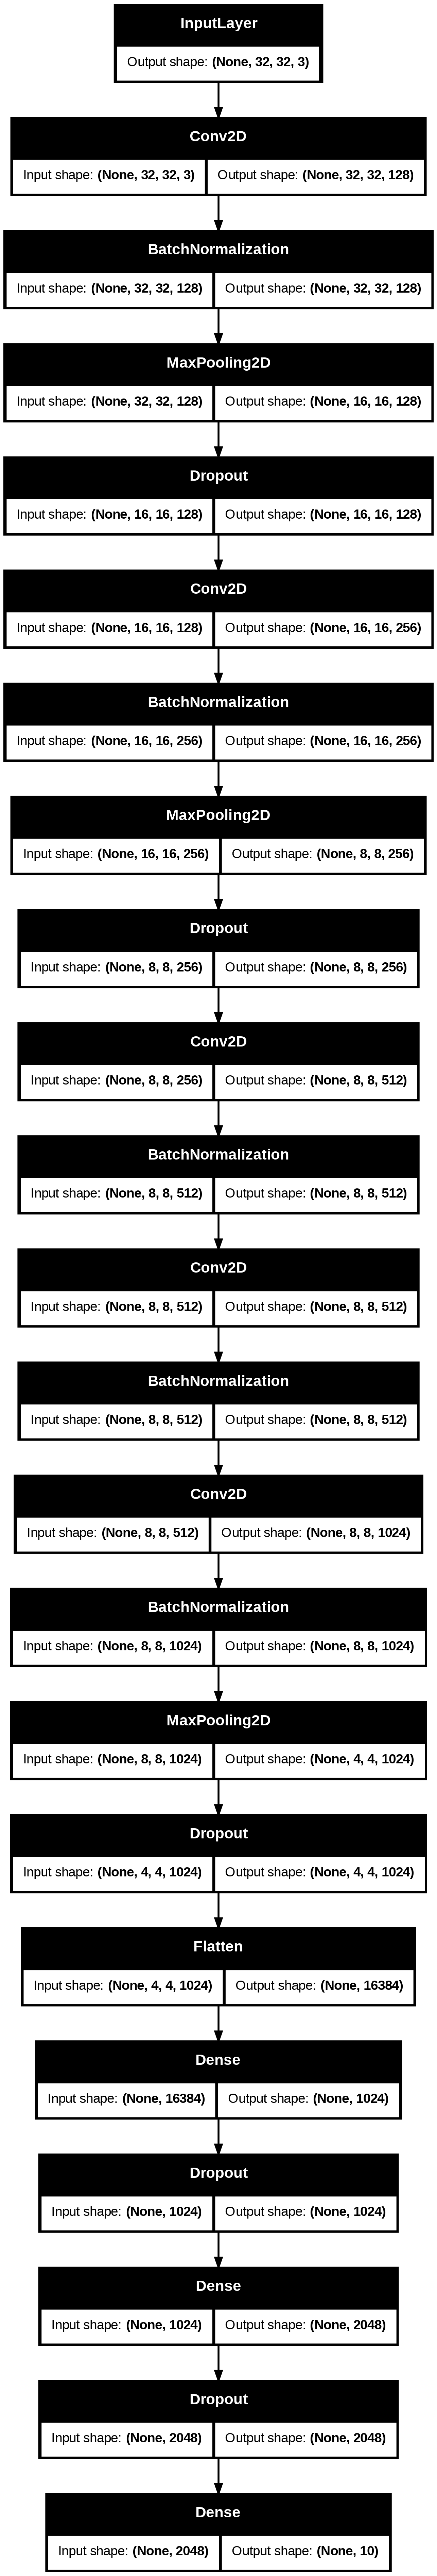

In [23]:
# Define model parameters
input_shape=X_train[0].shape # CIFAR-10 image size = (32, 32, 3)
num_classes = 10           # Number of classes for CIFAR-10

# Build the model using the Functional API
alexnet_scaled_model = AlexNetScaled(input_shape=input_shape, num_classes=num_classes)

# Summary of the model
alexnet_scaled_model.summary()
keras.utils.plot_model(alexnet_scaled_model, show_shapes=True)

In [24]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime
# Compile the model

optimizer = Adam(learning_rate=0.0005)  # SGD # Set the desired learning rate here

alexnet_scaled_model.compile(optimizer=optimizer, #'adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Create the TensorBoard callback
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Early stopping with patience of 5 epochs, monitoring validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
alexnet_scaled_model.fit(X_train, y_train, epochs=75, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.2179 - loss: 3.4110 - val_accuracy: 0.3056 - val_loss: 2.7603
Epoch 2/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.3719 - loss: 1.6878 - val_accuracy: 0.3834 - val_loss: 1.7971
Epoch 3/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4774 - loss: 1.4401 - val_accuracy: 0.5120 - val_loss: 1.4121
Epoch 4/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5599 - loss: 1.2331 - val_accuracy: 0.6020 - val_loss: 1.1051
Epoch 5/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6177 - loss: 1.0819 - val_accuracy: 0.6811 - val_loss: 0.8843
Epoch 6/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6636 - loss: 0.9703 - val_accuracy: 0.6762 - val_loss: 0.9784
Epoch 7/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6990 - loss: 0.8711 - val_accuracy: 0.7213 - val_loss: 0.8095
Epoch 8/75
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7292 - loss: 0.7916 - 

In [25]:
test_loss, test_accuracy = alexnet_scaled_model.evaluate(X_test, y_test, verbose=0)

In [26]:
print(test_loss, test_accuracy)

0.596862256526947 0.832099974155426
